## Data Mining project: Discover and describe areas of interest and events from geo-located data

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, kmeans_plusplus, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import re
from preprocessText import process_text,clean_text

ImportError: cannot import name 'clean_text' from 'preprocessText' (c:\Users\HP\Data_Mining\preprocessText.py)

In [2]:
data_path="flickr_data2.csv"
df=pd.read_csv(data_path)
df.head(n=5)

C:\Users\HP\AppData\Local\Temp\ipykernel_21076\3555437615.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(data_path)


id          user        lat      long  \
0  4395181099  30624617@N03  45.754858  4.821710   
1  4394748717  35853470@N00  45.753270  4.862953   
2  4394694699  11817998@N05  45.760655  4.846564   
3  4394803790  11545749@N06  45.784000  4.874072   
4  4394803554  11545749@N06  45.784000  4.874072   

                                                tags  \
0                 chair,lyon,rhône,chaise,rhônealpes   
1                                                NaN   
2                                         365,iphone   
3       nin,nineinchnails,gift,screening,toiou,avott   
4  lyon,nin,nineinchnails,gift,screening,toiou,avott   

                         title   date_taken_minute   date_taken_hour  \
0             Chaises avec vue                11.0                15   
1                          NaN                51.0                17   
2       59/365 - R46 V103 B163                29.0                17   
3  2010-01-29 Toiou Avott Lyon                15.0                20   
4  2010-01-28 Toiou Avott Lyon                10.0                20   

    date_taken_day   date_taken_month   date_taken_year  date_upload_minute  \
0               28                  2              2010                  23   
1               28                  2              2010                  52   
2               28                  2              2010                  33   
3               28                  1              2010                  38   
4               28                  1              2010                  38   

   date_upload_hour   date_upload_day   date_upload_month   date_upload_year  \
0                20              28.0                   2             2010.0   
1                17              28.0                   2             2010.0   
2                17              28.0                   2             2010.0   
3                12              28.0                   2             2010.0   
4                12              28.0                   2             2010.0   

   Unnamed: 16  Unnamed: 17  Unnamed: 18  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN

## Discover the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420240 entries, 0 to 420239
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   420240 non-null  int64  
 1    user                420240 non-null  object 
 2    lat                 420240 non-null  float64
 3    long                420240 non-null  float64
 4    tags                316730 non-null  object 
 5    title               381911 non-null  object 
 6    date_taken_minute   420239 non-null  float64
 7    date_taken_hour     420240 non-null  int64  
 8    date_taken_day      420240 non-null  int64  
 9    date_taken_month    420240 non-null  int64  
 10   date_taken_year     420240 non-null  int64  
 11   date_upload_minute  420228 non-null  object 
 12   date_upload_hour    420238 non-null  object 
 13   date_upload_day     420238 non-null  float64
 14   date_upload_month   420240 non-null  int64  
 15   date_upload_year

We notice that the Unnamed columns are all almost empty ,but are filled when data is incoherent . Finally , we decided to just eraze the rows where Unnamed columns are defined , and then we dropped the three columns .

In [4]:
df = df.drop_duplicates(subset=['id'], keep='first')
df = df[df[['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']].isnull().all(axis=1)]


df.drop(columns=['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168050 entries, 0 to 419137
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   168050 non-null  int64  
 1    user                168050 non-null  object 
 2    lat                 168050 non-null  float64
 3    long                168050 non-null  float64
 4    tags                126069 non-null  object 
 5    title               152273 non-null  object 
 6    date_taken_minute   168050 non-null  float64
 7    date_taken_hour     168050 non-null  int64  
 8    date_taken_day      168050 non-null  int64  
 9    date_taken_month    168050 non-null  int64  
 10   date_taken_year     168050 non-null  int64  
 11   date_upload_minute  168050 non-null  object 
 12   date_upload_hour    168050 non-null  object 
 13   date_upload_day     168050 non-null  float64
 14   date_upload_month   168050 non-null  int64  
 15   date_upload_year    1

We also thought about working on data points located in the Lyon region in a defined radius . We define this zone by       

lat_min, lat_max = 45.65, 45.85


lon_min, lon_max = 4.75, 4.95

In [5]:


# Define the bounding box coordinates for the Lyon region
lat_min, lat_max = 45.65, 45.85
lon_min, lon_max = 4.75, 4.95

# Calculate the center of the bounding box
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

# Create a map centered on the Lyon region
lyon_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Define the coordinates for the bounding box
bounding_box_coords = [
    [lat_min, lon_min],  # Bottom-left
    [lat_min, lon_max],  # Bottom-right
    [lat_max, lon_max],  # Top-right
    [lat_max, lon_min],  # Top-left
    [lat_min, lon_min]   # Close the polygon
]

# Add the bounding box to the map
folium.PolyLine(bounding_box_coords, color='blue', weight=2).add_to(lyon_map)

# Display the map
lyon_map.save("lyon_region_map.html")
lyon_map  # This will render the map in a Jupyter Notebook environment if supported



In [6]:


# Filter the DataFrame based on latitude and longitude ranges
filtered_df = df[(df[' lat'] >= lat_min) & (df[' lat'] <= lat_max) &
                 (df[' long'] >= lon_min) & (df[' long'] <= lon_max)]

# Display the filtered DataFrame
filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 161654 entries, 0 to 419137
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   161654 non-null  int64  
 1    user                161654 non-null  object 
 2    lat                 161654 non-null  float64
 3    long                161654 non-null  float64
 4    tags                121622 non-null  object 
 5    title               146375 non-null  object 
 6    date_taken_minute   161654 non-null  float64
 7    date_taken_hour     161654 non-null  int64  
 8    date_taken_day      161654 non-null  int64  
 9    date_taken_month    161654 non-null  int64  
 10   date_taken_year     161654 non-null  int64  
 11   date_upload_minute  161654 non-null  object 
 12   date_upload_hour    161654 non-null  object 
 13   date_upload_day     161654 non-null  float64
 14   date_upload_month   161654 non-null  int64  
 15   date_upload_year    1

In [7]:
sampled_df=filtered_df.sample(n=10000,random_state=42)
def lat_long_to_cartesian(lat, long):
    lat_rad = np.radians(lat)
    long_rad = np.radians(long)
    x = np.cos(lat_rad) * np.cos(long_rad)
    y = np.cos(lat_rad) * np.sin(long_rad)
    z = np.sin(lat_rad)
    return np.array([x, y, z])


coords = sampled_df[[' lat', ' long']].to_numpy()
cartesian_coords = np.array([lat_long_to_cartesian(lat, long) for lat, long in coords])
x_squared_norms = np.sum(cartesian_coords ** 2, axis=1)

here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 20 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 21 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 22 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 23 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 24 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 25 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 26 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 27 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 28 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 29 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 30 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 31 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 32 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 33 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 34 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 35 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 36 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 37 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 38 clusters
here


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Processed 39 clusters


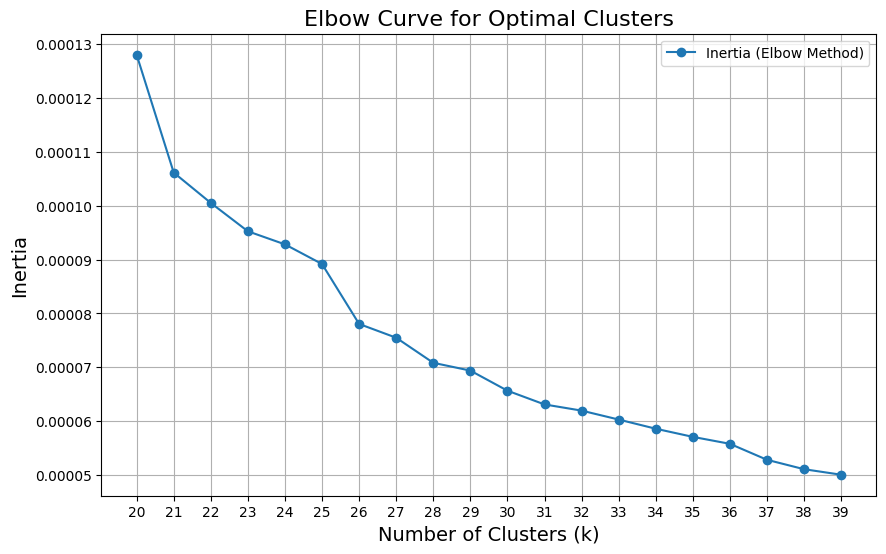

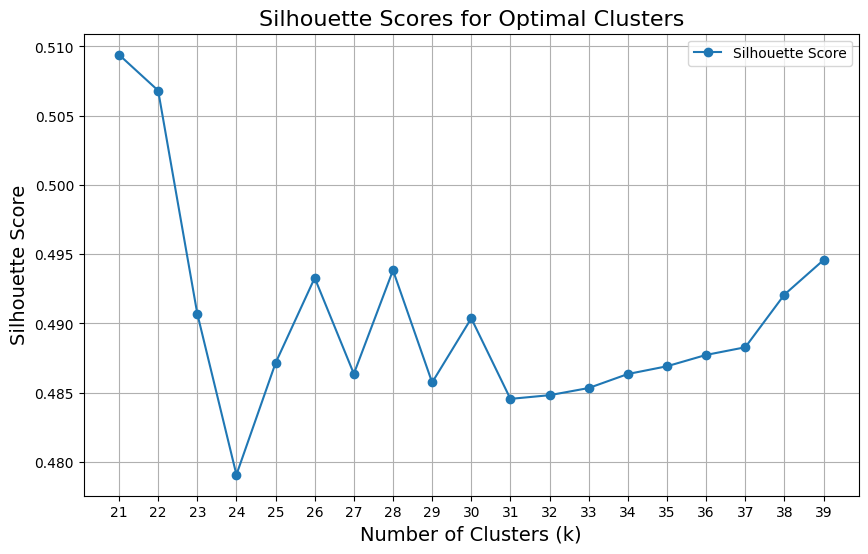

In [8]:
# Define the range of cluster numbers to test
cluster_range = range(20, 40)
inertia_values = []
silhouette_scores = []

# Compute inertia and silhouette scores for each number of clusters
for k in cluster_range:
    # Use kmeans_plusplus to initialize centroids
    init_centers, _ = kmeans_plusplus(cartesian_coords, n_clusters=k, random_state=42, x_squared_norms=x_squared_norms)
    print("here")
    # Fit KMeans with initialized centroids
    kmeans = KMeans(n_clusters=k, init=init_centers, n_init=5, random_state=42,verbose=0)
    kmeans.fit(cartesian_coords)
    
    # Store inertia value
    inertia_values.append(kmeans.inertia_)
    
    # Compute silhouette score for k > 1
    if k > 1:
        silhouette_scores.append(silhouette_score(cartesian_coords, kmeans.labels_))
    else:
        silhouette_scores.append(None)  # Silhouette score is undefined for k=1
    
    print(f'Processed {k} clusters')

# Plot the elbow curve (inertia values)
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', label='Inertia (Elbow Method)')
plt.title('Elbow Curve for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(cluster_range)
plt.legend()
plt.grid(True)
plt.show()

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range[1:], silhouette_scores[1:], marker='o', label='Silhouette Score')
plt.title('Silhouette Scores for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.xticks(cluster_range[1:])
plt.legend()
plt.grid(True)
plt.show()


we will go for 29 clusters to have a balance between well defined and compact clusters 

In [9]:
n_clusters=29
init_centers, _ = kmeans_plusplus(cartesian_coords, n_clusters=n_clusters, random_state=42, x_squared_norms=x_squared_norms)
kmeans = KMeans(n_clusters=n_clusters, init=init_centers, n_init=5, random_state=42)
kmeans.fit(cartesian_coords)

c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(init=array([[0.6951384 , 0.05870768, 0.71647471],
       [0.69422802, 0.05862813, 0.71736337],
       [0.69499113, 0.05904519, 0.71658984],
       [0.69576974, 0.05932446, 0.71581078],
       [0.69553652, 0.05865419, 0.71609262],
       [0.6950064 , 0.05924535, 0.7165585 ],
       [0.69542418, 0.06021325, 0.71607232],
       [0.69524442, 0.05907073, 0.71634199],
       [0.69518411, 0.05793049, 0.71649362],
       [0.69600063, 0.05803...
       [0.69546586, 0.05934972, 0.71610394],
       [0.6940695 , 0.05891734, 0.71749305],
       [0.69513102, 0.05886882, 0.71646865],
       [0.69526991, 0.0588384 , 0.71633637],
       [0.69563375, 0.05957803, 0.71592188],
       [0.69563737, 0.05880806, 0.71598203],
       [0.6952084 , 0.05880002, 0.71639922],
       [0.69488769, 0.05923864, 0.71667418],
       [0.69510055, 0.05878008, 0.71650549]]),
       n_clusters=29, n_init=5, random_state=42)

In [10]:

sampled_df['cluster'] = kmeans.fit_predict(cartesian_coords).astype(int) 

map_center = [sampled_df[' lat'].mean(), sampled_df[' long'].mean()]
cluster_map = folium.Map(location=map_center, zoom_start=13)

colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred',
    'beige', 'darkblue', 'darkgreen', 'cadetblue', 'pink', 'lightblue',
    'lightgreen', 'gray', 'black', 'lightgray', 'brown', 'darkpurple',
    'white', 'lightyellow', 'darkorange', 'teal', 'cyan', 'magenta'
]

for _, row in sampled_df.head(5000).iterrows():
    cluster_color = colors[int(row['cluster']) % len(colors)] 
    folium.CircleMarker(
        location=[row[' lat'], row[' long']],
        radius=5,
        color=cluster_color,
        fill=True,
        fill_color=cluster_color,
        fill_opacity=0.7
    ).add_to(cluster_map)

cluster_map.save("cluster_map.html")
cluster_map  


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Now we will try to do the same but using hierarchical clustering this time

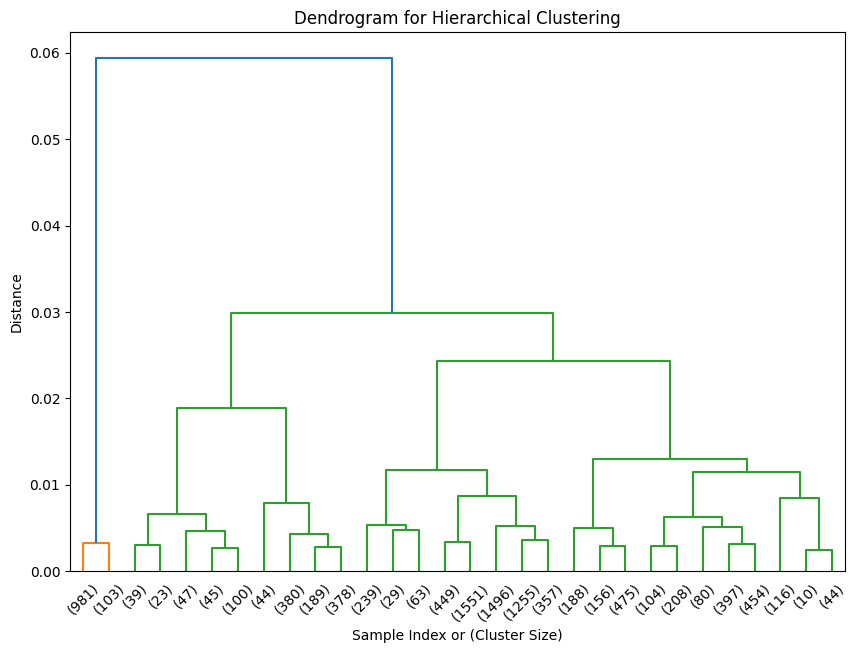

In [11]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')

sampled_df['cluster_hierarchical'] = hierarchical_clustering.fit_predict(cartesian_coords)

# Visualizing the Dendrogram (optional, for analysis)
linkage_matrix = linkage(cartesian_coords, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, show_leaf_counts=True)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.show()

A downside of hierarchical clustering is that it is memory excessive , and we are not able to process as much data as we are able to do usng kmeans . We were able to get results though using sampling . 

In [12]:
# Map Visualization for Hierarchical Clustering
map_center = [sampled_df[' lat'].mean(), sampled_df[' long'].mean()]
hierarchical_cluster_map = folium.Map(location=map_center, zoom_start=13)

# Assign colors to clusters (reuse color list or generate dynamically)
for _, row in sampled_df.head(5000).iterrows():
    cluster_color = colors[int(row['cluster_hierarchical']) % len(colors)]
    folium.CircleMarker(
        location=[row[' lat'], row[' long']],
        radius=5,
        color=cluster_color,
        fill=True,
        fill_color=cluster_color,
        fill_opacity=0.7
    ).add_to(hierarchical_cluster_map)

# Save the map as an HTML file
hierarchical_cluster_map.save("hierarchical_cluster_map.html")

# Display the map
hierarchical_cluster_map

#### Now We start to do the NLP part

We start by processing the two textual columns  'tags' and 'title'.  We will tokenize the text,remove the stopwords, and finally reduce the words to their root form

In [13]:
filtered_df

id           user        lat      long  \
0        4395181099   30624617@N03  45.754858  4.821710   
1        4394748717   35853470@N00  45.753270  4.862953   
2        4394694699   11817998@N05  45.760655  4.846564   
3        4394803790   11545749@N06  45.784000  4.874072   
4        4394803554   11545749@N06  45.784000  4.874072   
...             ...            ...        ...       ...   
413844  48994955623   23723681@N05  45.785599  4.813400   
413845  48995498101   23723681@N05  45.784841  4.812855   
413846  48994653443  128086472@N06  45.781863  4.875416   
419071  44824515765   14869313@N00  45.768700  4.840502   
419137  44995017704   48633948@N08  45.771852  4.833115   

                                                     tags  \
0                      chair,lyon,rhône,chaise,rhônealpes   
1                                                     NaN   
2                                              365,iphone   
3            nin,nineinchnails,gift,screening,toiou,avott   
4       lyon,nin,nineinchnails,gift,screening,toiou,avott   
...                                                   ...   
413844                                                NaN   
413845                                                NaN   
413846                                                NaN   
419071  france,auvergnerhônealpes,auvergnerhonealpes,r...   
419137  lyon,1714,4814we69,man,hess,nmt222,trolleybus,...   

                              title   date_taken_minute   date_taken_hour  \
0                  Chaises avec vue                11.0                15   
1                               NaN                51.0                17   
2            59/365 - R46 V103 B163                29.0                17   
3       2010-01-29 Toiou Avott Lyon                15.0                20   
4       2010-01-28 Toiou Avott Lyon                10.0                20   
...                             ...                 ...               ...   
413844              20190918_155502                55.0                15   
413845              20190918_155720                57.0                15   
413846      L’égout et les couleurs                42.0                16   
419071    Rhône river, Lyon, France                41.0                11   
419137        Lyon 1714 Rue Pouteau                20.0                14   

         date_taken_day   date_taken_month   date_taken_year  \
0                    28                  2              2010   
1                    28                  2              2010   
2                    28                  2              2010   
3                    28                  1              2010   
4                    28                  1              2010   
...                 ...                ...               ...   
413844               18                  9              2019   
413845               18                  9              2019   
413846               30                 10              2019   
419071               27                 10              2018   
419137               18                 10              2017   

        date_upload_minute  date_upload_hour   date_upload_day  \
0                       23                20              28.0   
1                       52                17              28.0   
2                       33                17              28.0   
3                       38                12              28.0   
4                       38                12              28.0   
...                    ...               ...               ...   
413844                13.0                13               1.0   
413845                13.0                13               1.0   
413846                33.0                11               1.0   
419071                 9.0                22               5.0   
419137                19.0                21               4.0   

         date_upload_month   date_upload_year  
0                        2             2

In [14]:
filtered_df['processed_title'] = filtered_df[' title'].apply(process_text)

C:\Users\HP\AppData\Local\Temp\ipykernel_21076\161293347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['processed_title'] = filtered_df[' title'].apply(process_text)


In [15]:
filtered_df['processed_tags'] = filtered_df[' tags'].apply(process_text)

C:\Users\HP\AppData\Local\Temp\ipykernel_21076\1613531878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['processed_tags'] = filtered_df[' tags'].apply(process_text)


We will remove numerical data from the texts

In [ ]:

def clean_text(text):
    if text is None or pd.isna(text):
        return ''
    cleaned_text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)  # Keeps only letters and spaces
    return cleaned_text
filtered_df['processed_tags'] = filtered_df['processed_tags'].apply(clean_text)
filtered_df['processed_title'] = filtered_df['processed_title'].apply(clean_text)

C:\Users\HP\AppData\Local\Temp\ipykernel_21076\4008780134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['processed_tags'] = filtered_df['processed_tags'].apply(clean_text)
C:\Users\HP\AppData\Local\Temp\ipykernel_21076\4008780134.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['processed_title'] = filtered_df['processed_title'].apply(clean_text)


In [41]:
filtered_df

id           user        lat      long  \
0        4395181099   30624617@N03  45.754858  4.821710   
1        4394748717   35853470@N00  45.753270  4.862953   
2        4394694699   11817998@N05  45.760655  4.846564   
3        4394803790   11545749@N06  45.784000  4.874072   
4        4394803554   11545749@N06  45.784000  4.874072   
...             ...            ...        ...       ...   
413844  48994955623   23723681@N05  45.785599  4.813400   
413845  48995498101   23723681@N05  45.784841  4.812855   
413846  48994653443  128086472@N06  45.781863  4.875416   
419071  44824515765   14869313@N00  45.768700  4.840502   
419137  44995017704   48633948@N08  45.771852  4.833115   

                                                     tags  \
0                      chair,lyon,rhône,chaise,rhônealpes   
1                                                     NaN   
2                                              365,iphone   
3            nin,nineinchnails,gift,screening,toiou,avott   
4       lyon,nin,nineinchnails,gift,screening,toiou,avott   
...                                                   ...   
413844                                                NaN   
413845                                                NaN   
413846                                                NaN   
419071  france,auvergnerhônealpes,auvergnerhonealpes,r...   
419137  lyon,1714,4814we69,man,hess,nmt222,trolleybus,...   

                              title   date_taken_minute   date_taken_hour  \
0                  Chaises avec vue                11.0                15   
1                               NaN                51.0                17   
2            59/365 - R46 V103 B163                29.0                17   
3       2010-01-29 Toiou Avott Lyon                15.0                20   
4       2010-01-28 Toiou Avott Lyon                10.0                20   
...                             ...                 ...               ...   
413844              20190918_155502                55.0                15   
413845              20190918_155720                57.0                15   
413846      L’égout et les couleurs                42.0                16   
419071    Rhône river, Lyon, France                41.0                11   
419137        Lyon 1714 Rue Pouteau                20.0                14   

         date_taken_day   date_taken_month   date_taken_year  \
0                    28                  2              2010   
1                    28                  2              2010   
2                    28                  2              2010   
3                    28                  1              2010   
4                    28                  1              2010   
...                 ...                ...               ...   
413844               18                  9              2019   
413845               18                  9              2019   
413846               30                 10              2019   
419071               27                 10              2018   
419137               18                 10              2017   

        date_upload_minute  date_upload_hour   date_upload_day  \
0                       23                20              28.0   
1                       52                17              28.0   
2                       33                17              28.0   
3                       38                12              28.0   
4                       38                12              28.0   
...                    ...               ...               ...   
413844                13.0                13               1.0   
413845                13.0                13               1.0   
413846                33.0                11               1.0   
419071                 9.0                22               5.0   
419137                19.0                21               4.0   

         date_upload_month   date_upload_year          processed_title  \
0             